In [13]:
import argparse
import os
import torch
import pyro
import json
import math
import scipy
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from pyro.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
import seaborn as sns

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *
from utils.BayesSpace import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import GPUtil

In [ ]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    
    # Get all available GPUs sorted by memory usage (lowest first)
    available_gpus = GPUtil.getAvailable(order='memory', limit=1)
    
    if available_gpus:
        selected_gpu = available_gpus[0]
        
        # Set the GPU with the lowest memory usage
        torch.cuda.set_device(selected_gpu)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    print("No GPU available :(")

# Synthetic Data Generation

In [15]:
def find_indices_within_distance(grid, r=1):
    indices_within_distance = np.empty((grid.shape[0], grid.shape[1]), dtype=object)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            # Check all neighboring cells within a Manhattan distance of 1
            neighbors = []
            for x in range(max(0, i-r), min(grid.shape[0], i+r+1)):
                for y in range(max(0, j-r), min(grid.shape[1], j+r+1)):
                    if abs(x - i) + abs(y - j) <= r:
                        neighbors.append((x, y))
            indices_within_distance[i, j] = neighbors
    return indices_within_distance

def prepare_synthetic_data(
    grid_size = 50,
    num_clusters = 5,
    data_dimension = 5,
    random_seed_weights = 1,
    random_seed_data = 1,
    r = 1
):

    # Set grid dimensions and random seed
    np.random.seed(random_seed_weights)

    # Step 1: Initialize an empty grid and randomly assign cluster "patches"
    ground_truth = np.zeros((grid_size, grid_size), dtype=int)
    for cluster_id in range(1, num_clusters):
        # Randomly choose a center for each cluster
        center_x, center_y = np.random.randint(0, grid_size, size=2)
        radius = np.random.randint(10, 30)  # Random radius for each cluster region

        # Assign cluster_id to a circular region around the chosen center
        for i in range(grid_size):
            for j in range(grid_size):
                if (i - center_x) ** 2 + (j - center_y) ** 2 < radius ** 2:
                    ground_truth[i, j] = cluster_id

    # Step 2: Add random noise within each patch
    noise_level = 0.5
    noisy_grid = ground_truth + noise_level * np.random.randn(grid_size, grid_size)

    # Step 3: Apply Gaussian smoothing to create spatial clustering
    sigma = 3  # Controls the amount of clustering smoothness
    smoothed_grid = scipy.ndimage.gaussian_filter(noisy_grid, sigma=sigma)

    # Step 4: Threshold to obtain integer values
    clustered_grid = np.round(smoothed_grid).astype(int)
    clustered_grid = np.clip(clustered_grid, 0, num_clusters)

    # Plot the clustered grid with flipped y axis
    # fig, ax = plt.subplots(figsize=(6, 6)) 
    # ax.imshow(clustered_grid, cmap="tab20", interpolation="nearest", origin='lower')  # Flip y axis by setting origin to 'lower'
    # ax.set_title("Ground Truth Clusters")
    # plt.colorbar(ax.imshow(clustered_grid, cmap="rainbow", interpolation="nearest", origin='lower'), ax=ax, label="Cluster Level", ticks=range(num_clusters + 1))  # Flip y axis by setting origin to 'lower'
    # import os
    # os.makedirs("results/SYNTHETIC", exist_ok=True)
    # plt.savefig("results/SYNTHETIC/ground_truth.png")
    
    # plt.show()

    # get the rook neighbors for each spot
    indices = find_indices_within_distance(clustered_grid, r=r)

    prior_weights = np.zeros((clustered_grid.shape[0] * clustered_grid.shape[1], num_clusters))

    # for each spot sample 
    for i in range(clustered_grid.shape[0]):
        for j in range(clustered_grid.shape[1]):
            for neighbor in indices[i, j]:
                prior_weights[i * clustered_grid.shape[1] + j, clustered_grid[neighbor]] += 1
    prior_weights = prior_weights / prior_weights.sum(axis=1, keepdims=True)

    # Initialize lists for means, covariances, and data points
    means = []
    covariances = []
    data = np.empty((clustered_grid.shape[0] * clustered_grid.shape[1], data_dimension))

    # Generate means and covariances for each cluster
    for i in range(num_clusters):
        # Randomly set the mean close to the origin to encourage overlap
        mean = np.random.uniform(-5, 5, data_dimension)
        # Generate a diagonal covariance matrix with random magnitudes
        covariance = np.diag(np.random.rand(data_dimension) * 2.5)
        
        means.append(mean)
        covariances.append(covariance)
        
    # Generate samples from the mixture.
    np.random.seed(random_seed_data)
    for i, weights in enumerate(prior_weights):
        data[i] = np.sum(weights[k] * np.random.multivariate_normal(means[k], covariances[k], 1) for k in range(num_clusters))

    # Create an anndata object
    adata = ad.AnnData(data)

    # Add row and col index
    adata.obs['spot_number'] = np.arange(clustered_grid.shape[0] * clustered_grid.shape[1])
    adata.obs['spot_number'] = adata.obs['spot_number'].astype('category')
    adata.obs['row'] = np.repeat(np.arange(clustered_grid.shape[0]), clustered_grid.shape[1])
    adata.obs['col'] = np.tile(np.arange(clustered_grid.shape[1]), clustered_grid.shape[0])
    clustering = XeniumCluster(data=adata.X, dataset_name="SYNTHETIC")
    clustering.xenium_spot_data = adata

    Xenium_to_BayesSpace(clustering.xenium_spot_data, dataset_name="SYNTHETIC", spot_size=grid_size)

    return clustering.xenium_spot_data.X, clustering.xenium_spot_data.obs[['row', 'col']], clustering, prior_weights, means, covariances

def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    clustering.pca(clustering.xenium_spot_data, num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            clustering.pca(clustering.xenium_spot_data, num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]

    # the last one is to regain var/obs access from original data
    return data, spatial_locations, clustering 

In [92]:
from scipy.optimize import linear_sum_assignment
def match_labels(true_soft_assignments, inferred_soft_assignments):
    """
    Match inferred cluster labels to true cluster labels using the Hungarian algorithm for each row.
    Args:
        true_soft_assignments (torch.Tensor): True soft cluster assignments (N x K).
        inferred_soft_assignments (torch.Tensor): Inferred soft cluster assignments (N x K).
    Returns:
        torch.Tensor: Permutation indices for each row of inferred labels.
    """
    # Compute pairwise distances between true and inferred soft assignments for each row
    distance_matrix = torch.cdist(true_soft_assignments, inferred_soft_assignments, p=2)
    
    # Find optimal matching between true and inferred clusters for each row
    row_ind, col_ind = linear_sum_assignment(distance_matrix.cpu().numpy())
    
    # Re-order the columns of each row according to the optimal matching
    reordered_inferred_soft_assignments = inferred_soft_assignments[torch.tensor(col_ind)]
    
    return reordered_inferred_soft_assignments  # Re-ordered inferred soft assignments

def Xenium_SVI(
        gene_data,
        spatial_locations,
        original_adata,
        spot_size = 100,
        data_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        dataset_name="hBreast",
        custom_init=False,
        num_clusters=6, 
        batch_size=512,
        neighborhood_size=2,
        neighborhood_agg="sum",
        uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99],
        evaluate_markers=False, 
        num_posterior_samples=100,
        mu_prior_scale=1.0,
        sigma_prior_scale=1.0,
        logits_prior_scale=1.0,
        learn_global_variances=False,
        weighted_p=5,
    ):

    if torch.cuda.is_available():
        print("YAY! GPU available :3")
        
        # Get all available GPUs sorted by memory usage (lowest first)
        available_gpus = GPUtil.getAvailable(order='memory', limit=1)
        
        if available_gpus:
            selected_gpu = available_gpus[0]
            
            # Set the GPU with the lowest memory usage
            torch.cuda.set_device(selected_gpu)
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
            
            print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
        else:
            print("No GPUs available with low memory usage.")
    else:
        print("No GPU available :(")

        print(f"Batch Size is {batch_size}.")

    def custom_cluster_initialization(original_adata, method, K=17):

        original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

        # This function initializes clusters based on the specified method
        if method == "K-Means":
            initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
        elif method == "Hierarchical":
            initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, num_clusters=K)
        elif method == "Leiden":
            initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
        elif method == "Louvain":
            initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
        elif method == "mclust":
            original_adata.pca(original_adata.xenium_spot_data, num_pcs)
            initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
        elif method == "random":
            initial_clusters = np.random.randint(0, K, size=original_adata.xenium_spot_data.X.shape[0])
        else:
            raise ValueError(f"Unknown method: {method}")

        return initial_clusters
    
    def save_filepath(model, component, sample_for_assignment=None):

        total_file_path = (
            f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
            f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}/"
            f"/SAMPLEFORASSIGNMENT={sample_for_assignment}/"
            f"/SPATIALPRIORMULT=DIRECT/SPOTSIZE={spot_size}/AGG={neighborhood_agg}/"
            f"MU_PRIOR={mu_prior_scale}/SIGMA_PRIOR={sigma_prior_scale}/LOGITS_PRIOR={logits_prior_scale}/"
            f"LEARN_GLOBAL_VARS={learn_global_variances}"
        )

        return total_file_path

    pyro.clear_param_store()

    # Clamping
    MIN_CONCENTRATION = 0.01

    spatial_init_data = StandardScaler().fit_transform(gene_data)
    gene_data = StandardScaler().fit_transform(gene_data)
    empirical_prior_means = torch.ones(num_clusters, spatial_init_data.shape[1])
    empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

    rows = spatial_locations["row"].astype(int)
    columns = spatial_locations["col"].astype(int)

    num_rows = max(rows) + 1
    num_cols = max(columns) + 1

    if custom_init:

        with plt.ioff():
            initial_clusters = custom_cluster_initialization(original_adata, custom_init, K=num_clusters)

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")
            

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        # _ = plt.savefig(
        #     f"{kmeans_clusters_filepath}/result.png"
        # )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        # plt.figure(figsize=(6, 6))
        # plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        # plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        # plt.title('Cluster Assignment with KMeans')

        if dataset_name == "DLPFC":
            # Create a DataFrame for easier handling
            data = pd.DataFrame({
                'ClusterAssignments': initial_clusters,
                'Region': original_adata.xenium_spot_data.obs["Region"]
            })

            # Drop rows where 'Region' is NaN
            filtered_data = data.dropna(subset=['Region'])

            # Calculate ARI and NMI only for the non-NaN entries
            ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            cluster_metrics = {
                "ARI": ari,
                "NMI": nmi
            }

            data_file_path = f"{data_mode}/{num_pcs}"

            if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
                os.makedirs(kmeans_cluster_metrics_filepath)
            with open(f"{kmeans_cluster_metrics_filepath}/mpd.json", 'w') as fp:
                json.dump(cluster_metrics, fp)

        for i in range(num_clusters):
            cluster_data = gene_data[initial_clusters == i]
            if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
                empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
                empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
        cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
        cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

    else:

        cluster_probs_prior = torch.ones((len(gene_data), num_clusters), dtype=float)

    locations_tensor = torch.as_tensor(spatial_locations.values, dtype=torch.float16, device='cuda')

    # Compute the number of elements in each dimension
    num_spots = cluster_probs_prior.shape[0]

    # Initialize an empty tensor for spatial cluster probabilities
    spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

    spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
    neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

    # Iterate over each spot
    for i in tqdm(range(num_spots)):

        # Select priors in the neighborhood
        priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
        # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
        # print(priors_in_neighborhood)

        # Compute the sum or mean, or apply a custom weighting function
        if neighborhood_agg == "sum":
            neighborhood_priors = priors_in_neighborhood.sum(dim=0)
        elif neighborhood_agg == "mean":
            neighborhood_priors = priors_in_neighborhood.mean(dim=0)
        else:
            locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
            neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
            distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
            def distance_weighting(x, p=weighted_p):
                weight = 1/(1 + x/spot_size) ** (1/weighted_p)
                # print(weight)
                return weight / weight.sum()
            neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
        # Update the cluster probabilities
        # print(neighborhood_expression)
        spatial_cluster_probs_prior[i] += neighborhood_priors
    
    spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
    sample_for_assignment_options = [False, True]

    num_prior_samples = num_posterior_samples
    for sample_for_assignment in sample_for_assignment_options:

        if sample_for_assignment:
            cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).mode(dim=0).values
            cluster_assignments_prior = cluster_assignments_prior_TRUE
        else:
            cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
            cluster_assignments_prior = cluster_assignments_prior_FALSE
        # Load the data
        data = torch.tensor(gene_data).float()

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_prior + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)
        
        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
        colormap = ListedColormap(colormap_colors)

        # plt.figure(figsize=(6, 6))
        # plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        # plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        # plt.title('Prior Cluster Assignment with BayXenSmooth')

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
            # _ = plt.savefig(
            #     f"{bayxensmooth_clusters_filepath}/prior_result.png"
            # )

    NUM_PARTICLES = 25
    expected_total_param_dim = 2 # K x D

    def model(data):

        with pyro.plate("clusters", num_clusters):

            # Define the means and variances of the Gaussian components
            cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, mu_prior_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, sigma_prior_scale).to_event(1))

        # Define priors for the cluster assignment probabilities and Gaussian parameters
        with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
            batch_data = data[ind]
            mu = torch.log(spatial_cluster_probs_prior[ind])
            cov_matrix = torch.eye(mu.shape[1], dtype=mu.dtype, device=mu.device) * logits_prior_scale
            cluster_probs_logits = pyro.sample("cluster_logits", dist.MultivariateNormal(mu, cov_matrix))
            cluster_probs = torch.softmax(cluster_probs_logits, dim=-1)
            # likelihood for batch
            if cluster_means.dim() == expected_total_param_dim:
                pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                        cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                        cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), +
                        cluster_probs
                    ), 
                    obs=batch_data
                )
            # likelihood for batch WITH vectorization of particles
            else:
                pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                        cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                        cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                        cluster_probs
                    ), 
                    obs=batch_data
                )

    def guide(data):
        # Initialize cluster assignment probabilities for the entire dataset
        cluster_probs_logits_q_mean = pyro.param("cluster_logits_q_mean", torch.log(spatial_cluster_probs_prior) + torch.randn_like(spatial_cluster_probs_prior) * 0.1)
        cluster_probs_logits_q_scale = pyro.param("cluster_logits_q_scale", torch.ones_like(spatial_cluster_probs_prior, dtype=spatial_cluster_probs_prior.dtype, device=spatial_cluster_probs_prior.device) * logits_prior_scale, dist.constraints.positive)

        with pyro.plate("clusters", num_clusters):
            # Global variational parameters for means and scales
            cluster_means_q_mean = pyro.param("cluster_means_q_mean", empirical_prior_means + torch.randn_like(empirical_prior_means) * 0.05)
            cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", empirical_prior_scales + torch.randn_like(empirical_prior_scales) * 0.01, constraint=dist.constraints.positive)
            if learn_global_variances:
                cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(empirical_prior_means) * mu_prior_scale, constraint=dist.constraints.positive)
                cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(empirical_prior_scales) * sigma_prior_scale, constraint=dist.constraints.positive)
                cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
                cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
            else:
                cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
                cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

        with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

            batch_probs_logits_q_mean = cluster_probs_logits_q_mean[ind]
            batch_probs_logits_q_scale = cluster_probs_logits_q_scale[ind]
            logits = pyro.sample("cluster_logits", dist.Normal(batch_probs_logits_q_mean, batch_probs_logits_q_scale).to_event(1))
            cluster_probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

    NUM_EPOCHS = 500
    NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))
    # Setup the optimizer
    def per_param_callable(param_name):
        if param_name == 'cluster_means_q_mean':
            return {"lr": 0.001, "betas": (0.9, 0.999)}
        elif param_name == 'cluster_scales_q_mean':
            return {"lr": 0.001, "betas": (0.9, 0.999)}
        else:
            return {"lr": 0.005, "betas": (0.9, 0.999)}

    scheduler = Adam(per_param_callable)

    # Setup the inference algorithm
    svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

    # Create a DataLoader for the data
    # Convert data to CUDA tensors before creating the DataLoader
    data = data.to('cuda')

    # Clear the param store in case we're in a REPL
    pyro.clear_param_store()

    epoch_pbar = tqdm(range(NUM_EPOCHS))
    current_min_loss = float('inf')
    PATIENCE = 5
    patience_counter = 0
    for epoch in epoch_pbar:
        epoch_pbar.set_description(f"Epoch {epoch}")
        running_loss = 0.0
        for step in range(NUM_BATCHES):
            loss = svi.step(data)
            running_loss += loss / batch_size
            # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
        # svi.optim.step()
        if epoch % 1 == 0:
            # print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
            # print(current_cluster_means[0])
            if running_loss > current_min_loss:
                patience_counter += 1
            else:
                current_min_loss = running_loss
                patience_counter = 0
            if patience_counter >= PATIENCE:
                break 
            # clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"])
            # morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
            # # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
            # marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
            # morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
            # # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}
            # print(morans_i_markers)

            if dataset_name == "DLPFC":
                # Create a DataFrame for easier handling
                cluster_data = pd.DataFrame({
                    'ClusterAssignments': cluster_assignments_q,
                    'Region': original_adata.xenium_spot_data.obs["Region"]
                })

                # Drop rows where 'Region' is NaN
                filtered_data = cluster_data.dropna(subset=['Region'])

                # Calculate ARI and NMI only for the non-NaN entries
                ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
                nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
                print(f"Step {step} : ARI = {ari} NMI = {nmi}")

    torch.set_default_tensor_type(torch.FloatTensor)

    # Grab the learned variational parameters
    sample_for_assignment_options = [False, True]

    for sample_for_assignment in sample_for_assignment_options:
        cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
        cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
        if sample_for_assignment:
            cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
            cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
            cluster_assignments_prior = cluster_assignments_prior_TRUE
        else:
            cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
            cluster_assignments_q = cluster_probs_q.argmax(dim=1)
            cluster_assignments_prior = cluster_assignments_prior_FALSE
        
        cluster_means_q_mean = pyro.param("cluster_means_q_mean").cpu().detach()
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean").cpu().detach()
        cluster_probs_q = cluster_probs_q.cpu().detach()
        cluster_assignments_q = cluster_assignments_q.cpu().detach()
        cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

        # Plotting
        if spot_size:

            rows = spatial_locations["row"].astype(int)
            columns = spatial_locations["col"].astype(int)

            num_rows = max(rows) + 1
            num_cols = max(columns) + 1

            cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

            cluster_grid[rows, columns] = cluster_assignments_q + 1

            colors = plt.cm.get_cmap('viridis', num_clusters + 1)

            colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
            colormap = ListedColormap(colormap_colors)

            # plt.figure(figsize=(6, 6))
            # plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
            # plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
            # plt.title('Posterior Cluster Assignment with BayXenSmooth')

            match data_mode:
                case "PCA":
                    data_file_path = f"{data_mode}/{num_pcs}"
                case "HVG": 
                    data_file_path = f"{data_mode}/{hvg_var_prop}"
                case "ALL":
                    data_file_path = f"{data_mode}"
                case _:
                    raise ValueError("The data mode specified is not supported.")

            if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
                os.makedirs(bayxensmooth_clusters_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_clusters_filepath}/result.png"
            )

            clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
            soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

            if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
                os.makedirs(bayxensmooth_similar_filepath)
            with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
                fp.write(str(torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()))

            # grab the mpd distance of cluster labels
            cluster_labels = np.unique(cluster_grid)
            mpd = {}
            for label in cluster_labels:
                current_cluster_locations = torch.stack(torch.where((cluster_grid == label)), axis=1).to(float)
                mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()

            if not os.path.exists(bayxensmooth_mpd_filepath := save_filepath("BayXenSmooth", "mpd", sample_for_assignment)):
                os.makedirs(bayxensmooth_mpd_filepath)
            with open(f"{bayxensmooth_mpd_filepath}/clusters_K={num_clusters}_mpd.json", 'w') as fp:
                json.dump(mpd, fp)

            cmap = get_cmap('rainbow')

            if evaluate_markers:

                if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
                    labels = np.unique(cluster_assignments_q)  # Define the number of clusters
                    gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
                    mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

                    # Loop through each cluster label
                    for label in labels:
                        # Find indexes of current cluster
                        current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                        
                        # Efficiently extract the rows for the current cluster using fancy indexing
                        expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                        
                        # Compute mean expressions; the result is still a csr_matrix
                        mean_expressions = expressions.mean(axis=0)
                        
                        # Convert mean_expressions to a dense format and then to a DataFrame
                        mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                        
                        # Append the result to the mean_expression_by_cluster DataFrame
                        mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
                else:
                    # identify marker genes within each cluster
                    mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

                    for label in range(num_clusters):
                        current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                        expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                        mean_expressions = expressions.mean(axis=0).to_frame().T
                        mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

                for i, gene in enumerate(mean_expression_by_cluster.columns):
                    # using subplots() to draw vertical lines 
                    fig, ax = plt.subplots(figsize=(6, 6)) 
                    ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                    
                    # drawing the markers
                    ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                    ax.set_ylim(0) 
                    
                    # formatting and details 
                    ax.set_xlabel('Cluster Label') 
                    ax.set_ylabel('Mean Expression') 
                    ax.set_title(gene) 
                    ax.set_xticks(mean_expression_by_cluster[gene].index) 
                    if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                        os.makedirs(f"{bayxensmooth_expression_filepath}")
                    _ = plt.savefig(
                        f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                    )
            
            # confidence mapping
            cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

            cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

            heatmap_bins = 21
            colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
            colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
            colormap = ListedColormap(colormap_colors)

            # plt.figure(figsize=(6, 6))
            # plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
            # # plt.xticks([])  # Remove x-axis tick marks
            # # plt.yticks([])  # Remove y-axis tick marks
            # plt.gca().spines['top'].set_visible(False)  # Remove top border
            # plt.gca().spines['right'].set_visible(False)  # Remove right border
            # # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
            # # plt.gca().spines['left'].set_visible(False)  # Remove left border
            # cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
            # plt.title(r'$P(z_i = k)$')


            # colors = plt.cm.get_cmap('Greys', num_clusters + 1)
            # colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

            # confidence_proportions = {}
            # for uncertainty_value in uncertainty_values:
            #     confidence_matrix = (cluster_confidences > uncertainty_value).float()
            #     confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            #     plt.figure(figsize=(6, 6))
            #     plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            #     # plt.xticks([])  # Remove x-axis tick marks
            #     # plt.yticks([])  # Remove y-axis tick marks
            #     plt.gca().spines['top'].set_visible(False)  # Remove top border
            #     plt.gca().spines['right'].set_visible(False)  # Remove right border
            #     # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
            #     # plt.gca().spines['left'].set_visible(False)  # Remove left border
            #     cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
            #     # PLOT ALL UNCERTAINTY VALUESs
            #     plt.title(r'$\max_k \, P(z_i = k) > $' + f'{uncertainty_value}')
            #     if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
            #         os.makedirs(bayxensmooth_uncertainty_filepath)
            #     _ = plt.savefig(
            #         f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            #     )

        else:

            plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
            if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
                os.makedirs(bayxensmooth_clusters_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_clusters_filepath}/result.png"
            )

    return cluster_probs_q, cluster_means_q_mean, cluster_scales_q_mean


In [93]:
spot_size=50
data_mode="PCA"
num_pcs=3
hvg_var_prop=0.9
dataset_name="SYNTHETIC"
kmeans_init=True
custom_init="mclust"
spatial_init=True
num_clusters=5
batch_size=128
neighborhood_size=5
neighborhood_agg="mean"
concentration_amplification=10.0
# uncertainty_values = [1/num_clusters, 2/num_clusters, 3/num_clusters, 4/num_clusters, 5/num_clusters]
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers=False
spatial_normalize=0.00
mu_prior_scale = 10.0
sigma_prior_scale = 2.5
logits_prior_scale = 10.0
learn_global_variances = True

In [94]:
import torch

def compute_agreement_confusion_matrix(true_labels, posterior_samples, spatial_locations, pairwise_method="neighbors", r=1):
    
    if pairwise_method == "neighbors":

        pairs = []
        for index, observation in spatial_locations.iterrows():
            current_row = observation["row"] 
            current_col = observation["col"]
            neighboring_locations = spatial_locations[
                (spatial_locations["row"] >= current_row) 
                & (spatial_locations["row"] <= (current_row + r))
                & (spatial_locations["col"] >= current_col)
                & (spatial_locations["col"] <= (current_col + r))
            ].index.astype(int)
            pairs.extend(torch.cartesian_prod(torch.tensor([int(index)]), torch.tensor(neighboring_locations)))
    elif pairwise_method == "random":
        num_pairs = min(10000, len(true_labels) * (len(true_labels) - 1) // 2)
        indices = torch.randperm(len(true_labels), device=true_labels.device)[:num_pairs]
        pairs = torch.combinations(indices, r=2)
    else:
        raise ValueError("Invalid pairwise method. Use 'neighbors' or 'random'.")

    import matplotlib.pyplot as plt
    import seaborn as sns

    TP, FP, TN, FN = 0, 0, 0, 0

    for i, j in pairs:
        true_agree = (true_labels[i] == true_labels[j]).int()
        predicted_agree = (posterior_samples[i] == posterior_samples[j]).int()

        if true_agree == 1 and predicted_agree == 1:
            TP += 1
        elif true_agree == 0 and predicted_agree == 1:
            FP += 1
        elif true_agree == 0 and predicted_agree == 0:
            TN += 1
        elif true_agree == 1 and predicted_agree == 0:
            FN += 1

    TP /= len(pairs)
    FP /= len(pairs)
    TN /= len(pairs)
    FN /= len(pairs)

    # print({'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN})
    # confusion_matrix = [[TN, FP], [FN, TP]]
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Blues')
    # plt.xlabel('Agreements in Predicted Data')
    # plt.ylabel('Agreements in Ground Truth')
    # plt.title('Confusion Matrix')
    # plt.show()

    return {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}

In [95]:
N = 35
R = 1
conf_matrix_list = []
for n in range(1, N + 1):
    gene_data, spatial_locations, original_adata, prior_weights, true_means, true_covariances = prepare_synthetic_data(random_seed_weights=1, random_seed_data=n)
    cluster_probs_q, cluster_means_q_mean, cluster_scales_q_mean = Xenium_SVI(
        gene_data, 
        spatial_locations,
        original_adata,
        data_mode=data_mode,
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop, 
        dataset_name="SYNTHETIC", 
        spot_size=spot_size, 
        num_clusters=num_clusters, 
        batch_size=64, 
        custom_init="mclust",
        neighborhood_size=neighborhood_size,
        neighborhood_agg=neighborhood_agg,
        mu_prior_scale=mu_prior_scale,
        sigma_prior_scale=sigma_prior_scale,
        logits_prior_scale=logits_prior_scale,
        learn_global_variances=learn_global_variances
    )
    TRUE_ASSIGNMENTS = torch.tensor(prior_weights).argmax(axis=1)
    learned_assignments = cluster_probs_q.argmax(axis=1)
    original_adata.xenium_spot_data.obs["true_cluster"] = TRUE_ASSIGNMENTS
    original_adata.xenium_spot_data.obs["predicted_cluster"] = learned_assignments
    spatial_locations = spatial_locations.astype(int)
    conf_matrix = compute_agreement_confusion_matrix(TRUE_ASSIGNMENTS, learned_assignments, spatial_locations, pairwise_method="neighbors", r=R)
    conf_matrix_list.append(conf_matrix)
    print(conf_matrix)

YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 197:  39%|███▉      | 197/500 [02:31<03:53,  1.30it/s]


{'TP': 0.9082746658504234, 'FP': 0.03958779716355474, 'TN': 0.012753800632588512, 'FN': 0.03938373635343332}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 186:  37%|███▋      | 186/500 [02:24<04:03,  1.29it/s]


{'TP': 0.8984797469645954, 'FP': 0.03418018569533721, 'TN': 0.01816141210080604, 'FN': 0.0491786552392613}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 298:  60%|█████▉    | 298/500 [03:28<02:21,  1.43it/s]


{'TP': 0.9057239057239057, 'FP': 0.03203754718906234, 'TN': 0.02030405060708091, 'FN': 0.041934496479951025}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 350:  70%|███████   | 350/500 [04:32<01:56,  1.29it/s]


{'TP': 0.8519538822569126, 'FP': 0.040914192429343944, 'TN': 0.011427405366799306, 'FN': 0.09570451994694419}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 229:  46%|████▌     | 229/500 [02:58<03:30,  1.29it/s]


{'TP': 0.8898071625344353, 'FP': 0.02938475665748393, 'TN': 0.02295684113865932, 'FN': 0.05785123966942149}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 199:  40%|███▉      | 199/500 [02:34<03:53,  1.29it/s]


{'TP': 0.8617488011427406, 'FP': 0.03183348637894092, 'TN': 0.020508111417202327, 'FN': 0.08590960106111621}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 359:  72%|███████▏  | 359/500 [04:38<01:49,  1.29it/s]


{'TP': 0.9091929394959698, 'FP': 0.028568513416998266, 'TN': 0.023773084379144986, 'FN': 0.03846546270788695}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 226:  45%|████▌     | 226/500 [02:55<03:32,  1.29it/s]


{'TP': 0.9047036016732987, 'FP': 0.029180695847362513, 'TN': 0.023160901948780736, 'FN': 0.042954800530558106}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 218:  44%|████▎     | 218/500 [02:49<03:39,  1.28it/s]


{'TP': 0.9003162942556882, 'FP': 0.03438424650545863, 'TN': 0.017957351290684626, 'FN': 0.04734210794816855}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 199:  40%|███▉      | 199/500 [02:34<03:53,  1.29it/s]


{'TP': 0.9090909090909091, 'FP': 0.031425364758698095, 'TN': 0.020916233037445157, 'FN': 0.03856749311294766}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 349:  70%|██████▉   | 349/500 [04:30<01:57,  1.29it/s]


{'TP': 0.9042954800530558, 'FP': 0.030609121518212427, 'TN': 0.021732476277930825, 'FN': 0.04336292215080094}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 270:  54%|█████▍    | 270/500 [03:29<02:58,  1.29it/s]


{'TP': 0.886746250382614, 'FP': 0.03632282420161208, 'TN': 0.01601877359453117, 'FN': 0.06091215182124273}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 280:  56%|█████▌    | 280/500 [03:37<02:51,  1.29it/s]


{'TP': 0.8840934598510356, 'FP': 0.03315988164473013, 'TN': 0.01918171615141312, 'FN': 0.06356494235282115}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 223:  45%|████▍     | 223/500 [02:53<03:35,  1.29it/s]


{'TP': 0.9020508111417203, 'FP': 0.03183348637894092, 'TN': 0.020508111417202327, 'FN': 0.045607591062136514}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 266:  53%|█████▎    | 266/500 [03:26<03:01,  1.29it/s]


{'TP': 0.7810427507397204, 'FP': 0.030303030303030304, 'TN': 0.02203856749311295, 'FN': 0.16661565146413632}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 302:  60%|██████    | 302/500 [03:53<02:33,  1.29it/s]


{'TP': 0.9078665442301805, 'FP': 0.025711662075298437, 'TN': 0.02662993572084481, 'FN': 0.039791857973676154}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 289:  58%|█████▊    | 289/500 [03:43<02:42,  1.29it/s]


{'TP': 0.9068462401795735, 'FP': 0.027548209366391185, 'TN': 0.024793388429752067, 'FN': 0.040812162024283234}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 273:  55%|█████▍    | 273/500 [03:30<02:55,  1.29it/s]


{'TP': 0.8806244260789715, 'FP': 0.039791857973676154, 'TN': 0.012549739822467095, 'FN': 0.06703397612488522}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 256:  51%|█████     | 256/500 [03:18<03:09,  1.29it/s]


{'TP': 0.9101112131415162, 'FP': 0.03877155392306907, 'TN': 0.013570043873074176, 'FN': 0.03754718906234058}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 291:  58%|█████▊    | 291/500 [03:44<02:41,  1.29it/s]


{'TP': 0.8714416896235078, 'FP': 0.04111825323946536, 'TN': 0.01122334455667789, 'FN': 0.07621671258034894}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 223:  45%|████▍     | 223/500 [02:49<03:30,  1.31it/s]


{'TP': 0.9174574023058871, 'FP': 0.028466483011937556, 'TN': 0.023875114784205693, 'FN': 0.030200999897969594}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 390:  78%|███████▊  | 390/500 [04:59<01:24,  1.30it/s]


{'TP': 0.9265381083562901, 'FP': 0.024793388429752067, 'TN': 0.027548209366391185, 'FN': 0.021120293847566574}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 330:  66%|██████▌   | 330/500 [04:15<02:11,  1.29it/s]


{'TP': 0.9022548719518416, 'FP': 0.026017753290480564, 'TN': 0.026323844505662688, 'FN': 0.0454035302520151}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 282:  56%|█████▋    | 282/500 [03:36<02:47,  1.30it/s]


{'TP': 0.9046015712682379, 'FP': 0.03458830731558004, 'TN': 0.01775329048056321, 'FN': 0.043056830935618816}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 216:  43%|████▎     | 216/500 [02:45<03:37,  1.31it/s]


{'TP': 0.8180797877767575, 'FP': 0.04346495255586165, 'TN': 0.008876645240281604, 'FN': 0.12957861442709928}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 205:  41%|████      | 205/500 [02:38<03:48,  1.29it/s]


{'TP': 0.84726048362412, 'FP': 0.035302520151005, 'TN': 0.01703907764513825, 'FN': 0.10039791857973676}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 201:  40%|████      | 201/500 [02:35<03:52,  1.29it/s]


{'TP': 0.9032751760024488, 'FP': 0.03479236812570146, 'TN': 0.017549229670441792, 'FN': 0.04438322620140802}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 333:  67%|██████▋   | 333/500 [04:15<02:08,  1.30it/s]


{'TP': 0.8055300479542904, 'FP': 0.024283236404448526, 'TN': 0.028058361391694726, 'FN': 0.14212835424956638}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 263:  53%|█████▎    | 263/500 [03:23<03:03,  1.29it/s]


{'TP': 0.8774614835220896, 'FP': 0.03040506070809101, 'TN': 0.021936537088052238, 'FN': 0.07019691868176717}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 226:  45%|████▌     | 226/500 [02:54<03:31,  1.29it/s]


{'TP': 0.8357310478522599, 'FP': 0.04428119579634731, 'TN': 0.008060401999795939, 'FN': 0.11192735435159677}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 329:  66%|██████▌   | 329/500 [04:14<02:12,  1.29it/s]


{'TP': 0.9028670543822059, 'FP': 0.03438424650545863, 'TN': 0.017957351290684626, 'FN': 0.044791347821650854}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 337:  67%|██████▋   | 337/500 [04:21<02:06,  1.29it/s]


{'TP': 0.8927660442811958, 'FP': 0.030711151923273134, 'TN': 0.021630445872870115, 'FN': 0.05489235792266095}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 230:  46%|████▌     | 230/500 [03:02<03:34,  1.26it/s]


{'TP': 0.8870523415977961, 'FP': 0.03315988164473013, 'TN': 0.01918171615141312, 'FN': 0.06060606060606061}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 250:  50%|█████     | 250/500 [03:14<03:14,  1.28it/s]


{'TP': 0.8959289868380778, 'FP': 0.02785430058157331, 'TN': 0.024487297214569943, 'FN': 0.051729415365779005}
YAY! GPU available :3
Using GPU: 2 with the lowest memory usage.


Epoch 274:  55%|█████▍    | 274/500 [03:39<03:01,  1.25it/s]


{'TP': 0.8814406693194572, 'FP': 0.028568513416998266, 'TN': 0.023773084379144986, 'FN': 0.06621773288439955}


{'TP': 0.8849330243269637, 'FP': 0.032792572186511576, 'TN': 0.01954902560963167, 'FN': 0.06272537787689303}


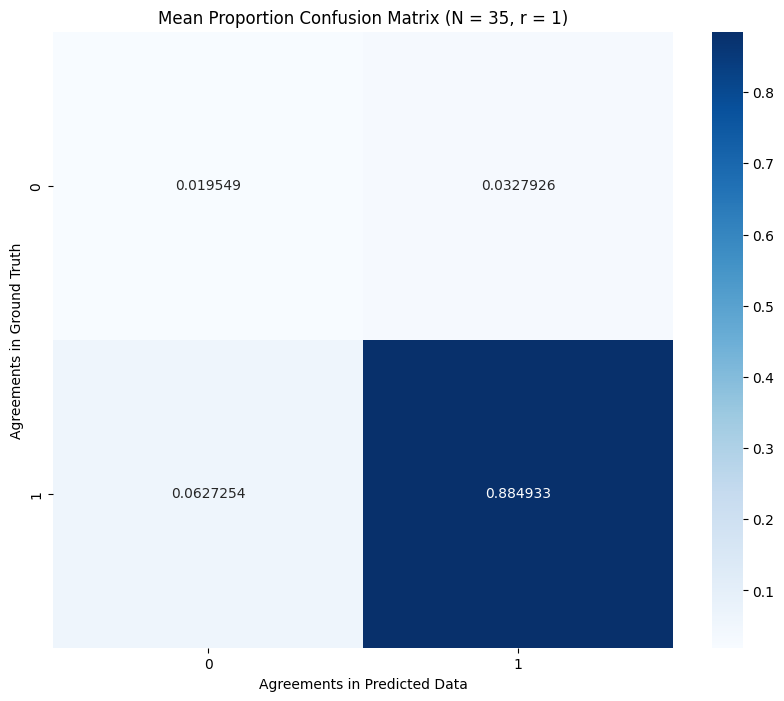

{'TP': 0.8984797469645954, 'FP': 0.03183348637894092, 'TN': 0.020508111417202327, 'FN': 0.0491786552392613}


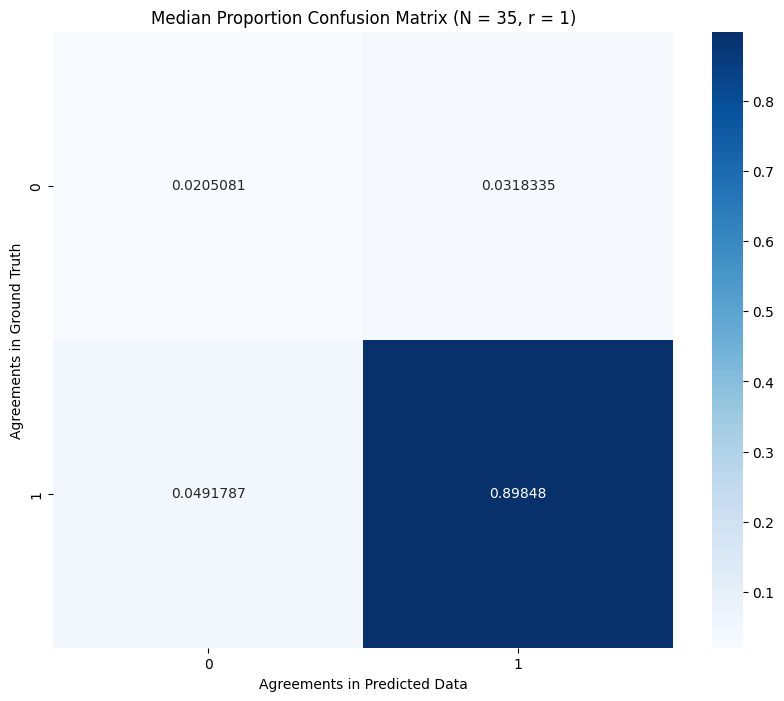

In [111]:
TP_list = [x["TP"] for x in conf_matrix_list]
TN_list = [x["TN"] for x in conf_matrix_list]
FP_list = [x["FP"] for x in conf_matrix_list]
FN_list = [x["FN"] for x in conf_matrix_list]

print({'TP': np.mean(TP_list), 'FP': np.mean(FP_list), 'TN': np.mean(TN_list), 'FN': np.mean(FN_list)})
confusion_matrix = [[np.mean(TN_list), np.mean(FP_list)], [np.mean(FN_list), np.mean(TP_list)]]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Agreements in Predicted Data')
plt.ylabel('Agreements in Ground Truth')
plt.title(f'Mean Proportion Confusion Matrix (N = {N}, r = {R})')
plt.show()

print({'TP': np.median(TP_list), 'FP': np.median(FP_list), 'TN': np.median(TN_list), 'FN': np.median(FN_list)})
confusion_matrix = [[np.median(TN_list), np.median(FP_list)], [np.median(FN_list), np.median(TP_list)]]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Blues')
plt.xlabel('Agreements in Predicted Data')
plt.ylabel('Agreements in Ground Truth')
plt.title(f'Median Proportion Confusion Matrix (N = {N}, r = {R})')
plt.show()

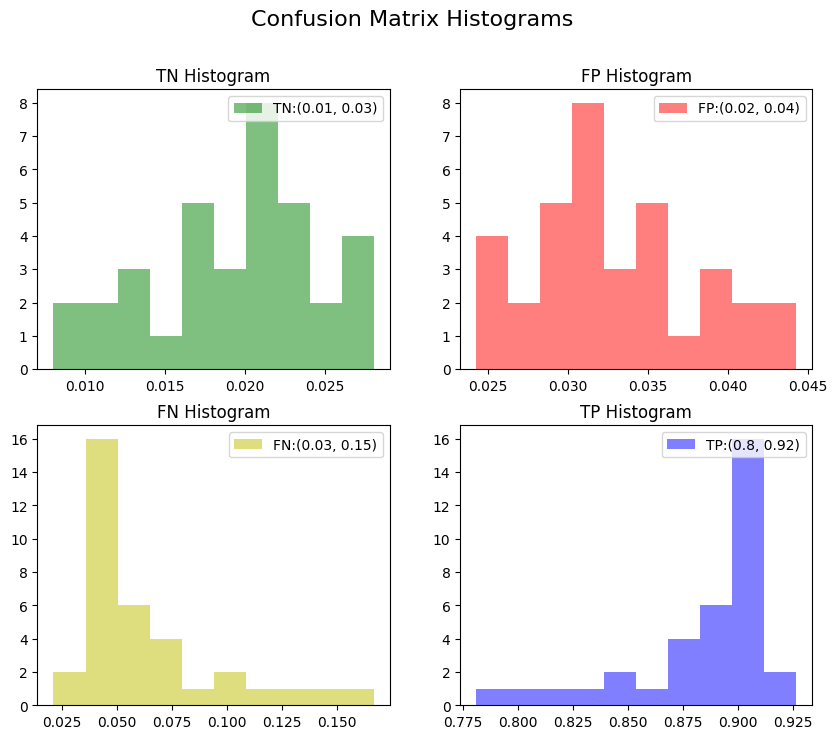

In [113]:
plt.figure(figsize=(10, 8))
plt.suptitle(f'Confusion Matrix Histograms: N={N}', fontsize=16)

plt.subplot(2, 2, 1)
plt.hist(TN_list, bins=10, alpha=0.5, color='g', label=f'TN:({np.round(np.percentile(TN_list, 2.5), 2)}, {np.round(np.percentile(TN_list, 97.5), 2)})')
plt.legend(loc='upper right')
plt.title('TN Histogram')

plt.subplot(2, 2, 2)
plt.hist(FP_list, bins=10, alpha=0.5, color='r', label=f'FP:({np.round(np.percentile(FP_list, 2.5), 2)}, {np.round(np.percentile(FP_list, 97.5), 2)})')
plt.legend(loc='upper right')
plt.title('FP Histogram')

plt.subplot(2, 2, 3)
plt.hist(FN_list, bins=10, alpha=0.5, color='y', label=f'FN:({np.round(np.percentile(FN_list, 2.5), 2)}, {np.round(np.percentile(FN_list, 97.5), 2)})')
plt.legend(loc='upper right')
plt.title('FN Histogram')

plt.subplot(2, 2, 4)
plt.hist(TP_list, bins=10, alpha=0.5, color='b', label=f'TP:({np.round(np.percentile(TP_list, 2.5), 2)}, {np.round(np.percentile(TP_list, 97.5), 2)})')
plt.legend(loc='upper right')
plt.title('TP Histogram')

plt.show()


In [ ]:
# from IPython.utils import io

# with io.capture_output():
N = 120
for n in range(1, N + 1):
    gene_data, spatial_locations, original_adata, prior_weights, true_means, true_covariances = prepare_synthetic_data(random_seed_weights=1, random_seed_data=n)
    cluster_probs_q, cluster_means_q_mean, cluster_scales_q_mean = Xenium_SVI(
        gene_data, 
        spatial_locations,
        original_adata,
        data_mode=data_mode,
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop, 
        dataset_name="SYNTHETIC", 
        spot_size=spot_size, 
        num_clusters=num_clusters, 
        batch_size=64, 
        custom_init="mclust",
        neighborhood_size=neighborhood_size,
        neighborhood_agg=neighborhood_agg,
        mu_prior_scale=mu_prior_scale,
        sigma_prior_scale=sigma_prior_scale,
        logits_prior_scale=logits_prior_scale,
        learn_global_variances=learn_global_variances
    )
    if n == 1:
        running_tally = torch.zeros_like(torch.tensor(prior_weights))
    prior_weights_relaxed = torch.softmax(torch.log(torch.tensor(prior_weights).clamp(0.01)), dim=1).cpu()
    cluster_probs_q = cluster_probs_q.cpu()
    print(torch.round(cluster_probs_q[:10], decimals=2))
    cluster_probs_q = match_labels(torch.tensor(prior_weights_relaxed).float(), cluster_probs_q.float())# Permute inferred results to match true labels
    print(prior_weights_relaxed[:10], torch.round(cluster_probs_q[:10], decimals=2))
    running_tally += (torch.tensor(prior_weights_relaxed).cpu() < cluster_probs_q.cpu()).float()
    print(running_tally)
    if n == N:
        print(running_tally / N)

In [ ]:
(torch.tensor(prior_weights_relaxed).cpu() < cluster_probs_q.cpu()).float()

In [ ]:
running_tally / N

In [ ]:
import matplotlib.pyplot as plt

comparison_tensor = torch.load('running_tally_normalized.pth')
plt.figure(figsize=(15, 6))
for i in range(comparison_tensor.shape[1]):
    plt.subplot(1, comparison_tensor.shape[1], i+1)
    plt.hist(comparison_tensor[:, i].cpu().numpy(), bins=20, alpha=0.7, label=f'Column {i}', color='b')
    plt.axvline(x=0.5, color='r', linestyle='--', linewidth=2)  # Add a red line at x = 0.5
    plt.title(f'Column {i} Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
gene_data, spatial_locations, original_adata, TRUE_WEIGHTS = prepare_synthetic_data()
TRUE_ASSIGNMENTS = TRUE_WEIGHTS.argmax(axis=1)
spatial_locations

In [9]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [10]:
def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, num_clusters=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
    elif method == "random":
        initial_clusters = np.random.randint(0, K, size=original_adata.xenium_spot_data.X.shape[0])
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

In [ ]:
# Clamping
MIN_CONCENTRATION = 0.001

num_posterior_samples = 1000

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

if custom_init or kmeans_init:

    if custom_init:

        initial_clusters = custom_cluster_initialization(original_adata, custom_init, K=num_clusters)
        print(custom_init, f"ARI: {ARI(initial_clusters, TRUE_ASSIGNMENTS)}", f"NMI: {NMI(initial_clusters, TRUE_ASSIGNMENTS)}")

    elif kmeans_init:

        kmeans_init_data = np.concatenate((spatial_locations, original_adata.xenium_spot_data.X), axis=1)
        kmeans_init_data = StandardScaler().fit_transform(kmeans_init_data)

        if spatial_normalize:

            spatial_dim = spatial_locations.shape[1]
            gene_dim = original_adata.xenium_spot_data.X.shape[1]
            spatial_factor = (gene_dim * spatial_normalize / (spatial_dim * (1 - spatial_normalize))) ** 0.5
            kmeans_init_data[:, :spatial_locations.shape[1]] *= spatial_factor

        kmeans = KMeans(n_clusters=num_clusters).fit(kmeans_init_data)

        initial_clusters = kmeans.predict(kmeans_init_data)

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")
        
    if kmeans_init and not custom_init:

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        _ = plt.savefig(
            f"{kmeans_clusters_filepath}/result.png"
        )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colors, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters), label='Cluster Values')
        plt.title('Cluster Assignment with KMeans')

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/mpd.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    for i in range(num_clusters):
        cluster_data = gene_data[initial_clusters == i]
        if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
            empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
            empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
    cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
    cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

else:

    cluster_probs_prior = torch.ones((len(gene_data), num_clusters), dtype=float)

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/spot_size)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 100
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colors, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [ ]:
# grab the mpd distance of cluster labels
mpd = {}
for label in range(1, num_clusters + 1):
    current_cluster_locations = torch.stack(torch.where((cluster_grid_PRIOR.cpu() == label)), axis=1).to(float)
    mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
sum(mpd.values()) / 1_000_000

In [13]:
empirical_prior_means_guide = empirical_prior_means.clone().detach()
empirical_prior_scales_guide = empirical_prior_scales.clone().detach()

In [14]:
learn_global_variances = True

In [15]:
torch.set_printoptions(sci_mode=False)
PRIOR_SCALE = np.sqrt(0.1) # higher means weaker
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 10.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 10.0).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        mu = torch.log(spatial_cluster_probs_prior[ind])
        cov_matrix = torch.eye(mu.shape[1], dtype=mu.dtype, device=mu.device) * 100.0
        cluster_probs_logits = pyro.sample("cluster_logits", dist.MultivariateNormal(mu, cov_matrix))
        cluster_probs = torch.softmax(cluster_probs_logits, dim=-1)
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), +
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_probs_logits_q_mean = pyro.param("cluster_logits_q_mean", torch.log(spatial_cluster_probs_prior) + torch.randn_like(spatial_cluster_probs_prior) * 0.1)
    cluster_probs_logits_q_scale = pyro.param("cluster_logits_q_scale", torch.ones_like(spatial_cluster_probs_prior, dtype=spatial_cluster_probs_prior.dtype, device=spatial_cluster_probs_prior.device) * 2.5, dist.constraints.positive)

    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", empirical_prior_means + torch.randn_like(empirical_prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", empirical_prior_scales + torch.randn_like(empirical_prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(empirical_prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(empirical_prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_probs_logits_q_mean = cluster_probs_logits_q_mean[ind]
        batch_probs_logits_q_scale = cluster_probs_logits_q_scale[ind]
        logits = pyro.sample("cluster_logits", dist.Normal(batch_probs_logits_q_mean, batch_probs_logits_q_scale).to_event(1))
        cluster_probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

In [ ]:
empirical_prior_means.shape, empirical_prior_scales.shape

In [ ]:
print(pyro.render_model(model, model_args=(data,), render_distributions=True, render_params=True))

In [ ]:
pyro.clear_param_store()
NUM_EPOCHS = 1000
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    elif "logit" in param_name:
        return {"lr": 0.01, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.005, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
cluster_means_trace = []
cluster_scales_trace = []
current_min_loss = float('inf')
PATIENCE = 15
patience_counter = 0
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
        # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
        current_cluster_means = pyro.param("cluster_means_q_mean").detach().cpu().numpy()
        cluster_means_trace.append(current_cluster_means)
        current_cluster_scales = pyro.param("cluster_scales_q_mean").detach().cpu().numpy()
        cluster_scales_trace.append(current_cluster_scales)
        # print(current_cluster_means[0])
        if running_loss > current_min_loss:
            patience_counter += 1
        else:
            current_min_loss = running_loss
            patience_counter = 0
        if patience_counter >= PATIENCE:
            break 
        l2_norm = torch.norm(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1) - spatial_cluster_probs_prior, p=2)
        # print(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1)[0])

        if dataset_name == "DLPFC":
            # Create a DataFrame for easier handling
            cluster_data = pd.DataFrame({
                'ClusterAssignments': cluster_assignments_q,
                'Region': original_adata.xenium_spot_data.obs["Region"]
            })

            # Drop rows where 'Region' is NaN
            filtered_data = cluster_data.dropna(subset=['Region'])

            # Calculate ARI and NMI only for the non-NaN entries
            ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
            print(f"Epoch {epoch} : ARI = {ari} NMI = {nmi}")

        elif dataset_name == "SYNTHETIC":
            num_posterior_samples = 1000
            sample_for_assignment_options = [True, False]
            for sample_for_assignment in sample_for_assignment_options:
                cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
                cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
                if sample_for_assignment:
                    cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
                    cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
                    cluster_assignments_prior = cluster_assignments_prior_TRUE
                else:
                    cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
                    cluster_assignments_q = cluster_probs_q.argmax(dim=1)
                    cluster_assignments_prior = cluster_assignments_prior_FALSE
                # Detach tensors and convert them to numpy before calling ARI and NMI functions
                cluster_assignments_q_np = cluster_assignments_q.detach().cpu().numpy()
                ari = ARI(cluster_assignments_q_np, TRUE_ASSIGNMENTS)
                nmi = NMI(cluster_assignments_q_np, TRUE_ASSIGNMENTS)
                print(f"Epoch {epoch}, {sample_for_assignment} : ARI = {round(ari, 2)} NMI = {round(nmi, 2)}")

In [ ]:
torch.abs(pyro.param("cluster_means_q_mean").detach() - empirical_prior_means).mean()

In [ ]:
pyro.param("cluster_means_q_mean").detach(), empirical_prior_means

In [18]:
# cluster_means_trace = np.array(cluster_means_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_means_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_means_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Mean Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break


In [19]:
# cluster_scales_trace = np.array(cluster_scales_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_scales_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_scales_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Scale Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break

In [ ]:
torch.set_default_tensor_type(torch.FloatTensor)

# Grab the learned variational parameters
num_posterior_samples = 1000
sample_for_assignment_options = [True, False]

for sample_for_assignment in sample_for_assignment_options:
    cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
    cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
    if sample_for_assignment:
        cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
        cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE
    
    cluster_means_q_mean = pyro.param("cluster_means_q_mean").cpu().detach()
    cluster_scales_q_mean = pyro.param("cluster_scales_q_mean").cpu().detach()
    cluster_probs_q = cluster_probs_q.cpu().detach()
    cluster_assignments_q = cluster_assignments_q.cpu().detach()
    cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colors, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            prior_similarity = torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()
            fp.write(str(prior_similarity))
            print(prior_similarity)

        # grab the mpd distance of cluster labels
        mpd = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid.cpu() == label)), axis=1).to(float)
            mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
        print("mpd", sum(mpd.values()) / 1_000_000)

        if not os.path.exists(bayxensmooth_mpd_filepath := save_filepath("BayXenSmooth", "mpd", sample_for_assignment)):
            os.makedirs(bayxensmooth_mpd_filepath)
        with open(f"{bayxensmooth_mpd_filepath}/mpd.json", 'w') as fp:
            json.dump(mpd, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        heatmap_bins = 21
        colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_confidences, cmap=colors, interpolation='nearest', origin='lower')
        # plt.xticks([])  # Remove x-axis tick marks
        # plt.yticks([])  # Remove y-axis tick marks
        plt.gca().spines['top'].set_visible(False)  # Remove top border
        plt.gca().spines['right'].set_visible(False)  # Remove right border
        # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
        # plt.gca().spines['left'].set_visible(False)  # Remove left border
        cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
        plt.title(r'$P(z_i = k)$')


        colors = plt.cm.get_cmap('Greys', num_clusters)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters)))

        confidence_proportions = {}
        for uncertainty_value in uncertainty_values:
            confidence_matrix = (cluster_confidences > uncertainty_value).float()
            confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            plt.figure(figsize=(6, 6))
            plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            # plt.xticks([])  # Remove x-axis tick marks
            # plt.yticks([])  # Remove y-axis tick marks
            plt.gca().spines['top'].set_visible(False)  # Remove top border
            plt.gca().spines['right'].set_visible(False)  # Remove right border
            # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
            # plt.gca().spines['left'].set_visible(False)  # Remove left border
            cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
            # PLOT ALL UNCERTAINTY VALUESs
            plt.title(r'$\max_k \, P(z_i = k) > $' + f'{uncertainty_value}')
            if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
                os.makedirs(bayxensmooth_uncertainty_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

In [ ]:
# KL Calculation
CLAMP = 0.000001
cluster_probs_prior = cluster_probs_prior.cpu().detach().clamp(CLAMP)
TRUE_WEIGHTS = torch.tensor(TRUE_WEIGHTS).clamp(CLAMP)
kl_prior_divergence = torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / cluster_probs_prior), dim=1)
kl_post_divergence = torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / cluster_probs_q), dim=1)
kl_prior_divergence.mean(), kl_post_divergence.mean()

In [ ]:
ARI(cluster_assignments_q, TRUE_ASSIGNMENTS)

In [ ]:
heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$\max_k P(z_i = k)$')

# confidence_proportions = {}
# for uncertainty_value in uncertainty_values:
#     confidence_matrix = (cluster_confidences > uncertainty_value).float()
#     confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
#     plt.figure(figsize=(6, 6))
#     plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
#     plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
#     # PLOT ALL UNCERTAINTY VALUESs
#     plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
#     if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
#         os.makedirs(bayxensmooth_uncertainty_filepath)
#     _ = plt.savefig(
#         f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
#     )

In [ ]:
plt.figure(figsize=(6, 6))
same_labels = (cluster_grid_PRIOR.cpu() == cluster_grid.cpu()).float() * 2 - 1
same_labels[cluster_grid_PRIOR.cpu() == 0] = 0
colors = plt.cm.get_cmap('bwr', heatmap_bins)
plt.imshow(same_labels, cmap=colors, interpolation='nearest', origin='lower')
plt.colorbar(ticks=[-1,0,1], label='Prior = Posterior', fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
print(f"Proportion of Same Labels: {same_labels.float().mean()}")
_ = plt.title(r'$w_{i, prior} = w_{i, posterior}$')